In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
from statsmodels.tsa.stattools import adfuller

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

# 함수

In [28]:
#3시간 단위
def divide_time_range2(time):
    if time < 300:
        return '0~3시'
    elif time < 600:
        return '3~6시' 
    elif time < 900:
        return '6~9시'
    elif time < 1200:
        return '9~12시'
    elif time < 1500:
        return '12~15시'
    elif time < 1800:
        return '15~18시'
    elif time < 2100:
        return '18~21시'
    else:
        return '21~24시'
    
# 1시간단위
def divide_time_range1(time):
    for hour in range(24):
        if time < (hour + 1) * 100:
            return f'{hour:02d}:00~{(hour + 1):02d}:00'

# 구간시간단위        
def divide_time_range(time):
    if time < 600:
        return '00:00~06:00'
    elif time < 1000:
        return '06:00~10:00' # 출근시간
    elif time < 1600:
        return '10:00~17:00'
    elif time < 2000:
        return '17:00~21:00' # 퇴근시간
    else:
        return '21:00~24:00'
    
    
###############################################################################################################################################
# 사리마 분석
def check_best_sarima(data,p,d,q,P,D,Q,count):
    if count ==0 : 
        fig_acf = plot_acf(data)
        # 그래프의 선 색상 변경
        plt.gca().lines[1].set_color('#336666')  # 두 번째 선의 색상을 주어진 색상으로 변경
        # 면적의 채우기 색상 변경
        plt.gca().collections[0].set_facecolor('#33cc99')  # 면적의 채우기 색상을 변경

        # PACF 그래프 그리기
        fig_pacf = plot_pacf(data)
        # 그래프의 선 색상 변경
        plt.gca().lines[1].set_color('#336666')  # 두 번째 선의 색상을 주어진 색상으로 변경
        # 면적의 채우기 색상 변경
        plt.gca().collections[0].set_facecolor('#33cc99')  # 면적의 채우기 색상을 변경

        # 그래프의 크기 변경
        plt.figure(figsize=(10, 10))  # 가로 10, 세로 6의 크기로 변경

        plt.show()

    model = SARIMAX(data.values, order=(p, d, q), seasonal_order=(P, D, Q, 5))  # 데이터를 넘파이 배열로 변환하여 사용
    model_fit = model.fit()
    if count == 0 :
        print(model_fit.summary())  
    forecast = model_fit.forecast(steps=1)[0]
    
    # 예측 결과 출력
    #print(model_fit.summary())

    return forecast

#사리마 분석
def sarima_test(data, IDs,p,d,q,P,D,Q,a,b,c):
    count=0
    result = []
    for 주거_ID in IDs:
        주거_data = data[data['대여소_ID'] == 주거_ID]
        주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
        주거_data.set_index('기준_날짜', inplace=True)
        arima_data = 주거_data.resample('D')['전체_건수'].sum()
        
        forecast = check_best_sarima(arima_data,p,d,q,P,D,Q,count)
        result.append([주거_ID, forecast,a,b,c])
        count+=1
    return result

###############################################################################################################################################

# 아리마 분석
def check_best_arima(data):
    best_aic = float("inf")  # 초기값 설정
    best_bic = float("inf")  # 초기값 설정
    best_model = None
    best_p, best_d, best_q = None, None, None
    
    for p in range(1, 6):
        for d in range(1, 3):
            for q in range(0, 6):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    bic = model_fit.bic
                    if bic < best_bic or (bic == best_bic and aic < best_aic):
                        best_aic = aic
                        best_bic = bic
                        best_model = model_fit
                        best_p, best_d, best_q = p, d, q
                except:
                    continue
    
    return best_model, best_p, best_d, best_q

def arima_test(data, IDs):
    for 주거_ID in IDs:
        주거_data = data[data['대여소_ID'] == 주거_ID]
        주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
        주거_data.set_index('기준_날짜', inplace=True)
        # 주거_data 샘플 -> 일별로 샘플림
        arima_data = 주거_data.resample('D')['전체_건수'].sum()
        
        best_model, best_p, best_d, best_q = check_best_arima(arima_data)
        if best_model is not None:
            print(f"대여소 {주거_ID}의 best model (p, d, q): ({best_p}, {best_d}, {best_q})")
            forecast = best_model.forecast(steps=1)  # 다음 시간대에 대한 예측값
            print(f"대여소 {주거_ID}의 다음 시간대 예측값: {forecast}")


######################################################################################################################
# 주중, 주말+휴일 나누는 함수

# 휴일 데이터
휴일 = [
    {"날짜": "2023-05-05"},
    {"날짜": "2023-05-29"},
    {"날짜": "2023-06-06"},
    {"날짜": "2023-08-15"},
    {"날짜": "2023-09-28"},
    {"날짜": "2023-09-29"},
    {"날짜": "2023-10-02"},
    {"날짜": "2023-10-03"},
    {"날짜": "2023-10-09"},
    {"날짜": "2023-12-25"},
    {"날짜": "2024-01-01"},
    {"날짜": "2024-02-09"},
    {"날짜": "2024-02-12"},
    {"날짜": "2024-03-01"},
]

# 주말과 휴일을 분류하는 함수 정의
def classify_weekend_and_holidays(df, holidays):
    # '일시' 열을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 주말(토요일: 5, 일요일: 6)인지 여부를 나타내는 열 추가
    df['요일'] = df['일시'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일
    df['주말'] = df['요일'].apply(lambda x: 1 if x >= 5 else 0)  # 토요일(5) 또는 일요일(6)이면 주말로 분류
    
    # 휴일인지 여부를 나타내는 열 추가
    df['휴일'] = df['일시'].apply(lambda x: 1 if str(x.date()) in [h['날짜'] for h in holidays] else 0)
    
    # 주말과 휴일으로 데이터 분리
    주말_df = df[(df['주말'] == 1) | (df['휴일'] == 1)]
    주중_df = df[(df['주말'] == 0) & (df['휴일'] == 0)]
    
    return 주말_df, 주중_df

# 회기분석 
- 20240504 자료 참조

In [5]:
# 데이터 불러오기
출발_구별_이동_수 = pd.read_csv('../../Data/따릉이/전체_구별이용량.csv', encoding='utf-8')

# 색상 설정
color_weekday = '#336666'  # R: 51, G: 102, B: 102

# Plotly Express를 사용하여 막대 그래프 그리기
fig = px.bar(출발_구별_이동_수, x='시작_대여소_구', y='이동_수', 
             title='<b>각 구별 따릉이 이용량</b>', 
             labels={'시작_대여소_구': '지역별', '이동_수': '대여 건수'},
             color_discrete_sequence=[color_weekday])  # 색상 설정
fig.update_layout(xaxis_title='지역별', yaxis_title='대여 건수', height=800)

# HTML 태그를 사용하여 bold체로 표시
fig.update_layout(title={'text': "<b>각 구별 따릉이 이용량</b>", 'x': 0.5})

fig.show()

In [6]:
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))
강서_데이터_주말 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_주말_휴일.csv',encoding='utf-8')

3385613


In [7]:
import pandas as pd
import plotly.express as px

# 데이터 불러오기
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv', encoding='utf-8')
강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv', encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv', encoding='utf-8')
강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
강서_데이터_주말 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_주말_휴일.csv', encoding='utf-8')

# 주중과 주말+휴일 전체 건수 계산
주중_전체_건수 = 강서_데이터[강서_데이터['주말'] == 0]['전체_건수'].sum()
주말_휴일_전체_건수 = 강서_데이터_주말[강서_데이터_주말['주말'] == 1]['전체_건수'].sum()

# 데이터프레임 생성
df = pd.DataFrame({'구분': ['주중', '주말+휴일'], '전체 건수': [주중_전체_건수, 주말_휴일_전체_건수]})

# 색상 설정
색상_주중 = '#336666'  # R: 51, G: 102, B: 102
색상_주말_휴일 = '#33cc99'  # R: 51, G: 204, B: 153
색상_지도 = {'주중': 색상_주중, '주말+휴일': 색상_주말_휴일}

# 그래프 그리기
그래프 = px.bar(df, x='구분', y='전체 건수', 
             title='주중 vs 주말+휴일 따릉이 이용량', 
             labels={'구분': '요일', '전체 건수': '이용량'},
             color='구분',
             color_discrete_map=색상_지도)  # 색상 설정
그래프.update_layout(font=dict(size=20, family="Arial, sans-serif", color="black", weight="bold"),
                  title_x=0.5,  # 제목 가운데 정렬
                  width=800,  # 그래프 너비 조절
                  height=600)  # 그래프 높이 조절
그래프.show()

In [8]:
import pandas as pd
import plotly.graph_objects as go

# Define the color codes
color_weekday = '#336666'  # R: 51, G: 102, B: 102
color_weekend = '#33cc99'  # R: 51, G: 204, B: 153



강서_데이터['시간대_구간'] = 강서_데이터['기준_시간대'].apply(divide_time_range2)
강서_데이터_주말['시간대_구간'] = 강서_데이터_주말['기준_시간대'].apply(divide_time_range2)

# 주중과 주말+휴일 시간대 구간별 전체 건수 계산
주중_시간대_건수 = 강서_데이터.groupby('시간대_구간')['전체_건수'].sum().reset_index()
주말_휴일_시간대_건수 = 강서_데이터_주말.groupby('시간대_구간')['전체_건수'].sum().reset_index()

# 시간대 구간을 정렬
시간대_구간_순서 = ['0~3시', '3~6시', '6~9시', '9~12시', '12~15시', '15~18시', '18~21시', '21~24시']
주중_시간대_건수 = 주중_시간대_건수.set_index('시간대_구간').reindex(시간대_구간_순서).reset_index()
주말_휴일_시간대_건수 = 주말_휴일_시간대_건수.set_index('시간대_구간').reindex(시간대_구간_순서).reset_index()

# 그래프 그리기
fig = go.Figure()

fig.add_trace(go.Bar(x=주중_시간대_건수['시간대_구간'], y=주중_시간대_건수['전체_건수'], name='주중', offsetgroup=0, marker_color=color_weekday))
fig.add_trace(go.Bar(x=주말_휴일_시간대_건수['시간대_구간'], y=주말_휴일_시간대_건수['전체_건수'], name='주말+휴일', offsetgroup=1, marker_color=color_weekend))

fig.update_layout(barmode='group', title='주중 vs 주말+휴일 따릉이 이용량 시간대별 비교', 
                  xaxis_title='시간대', yaxis_title='이용량',
                  font=dict(size=20, family="Arial, sans-serif", color="black", weight="bold"))
fig.show()

In [15]:
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)


top_20_ID = pd.read_csv('../../Data/따릉이/쏠림정도_top20_대여소.csv',encoding='utf-8')
# 주거와 상업으로 데이터 분할
주거_df = top_20_ID[top_20_ID['최종용도'] == '주거']
상업_df = top_20_ID[top_20_ID['최종용도'] == '상업']

# 주거 데이터에서 대여소_ID 추출
주거_IDs = 주거_df['대여소_ID'].unique()

# 상업 데이터에서 대여소_ID 추출
상업_IDs = 상업_df['대여소_ID'].unique()

강서_df = 강서_데이터[강서_데이터['시작_대여소_ID'].isin(주거_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '06:00~10:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['시작_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'시작_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

# ADF 테스트 수행
adf_result = adfuller(강서_df1[강서_df1['대여소_ID']=='ST-2056']['전체_건수'])


# ADF 통계량 및 p-value 출력
print(f'ADF 통계량: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# 결과 해석
if adf_result[1] < 0.05:
    print('p-value가 유의수준보다 작으므로 귀무가설을 기각합니다. 시계열 데이터는 정상성을 만족합니다.')
else:
    print('p-value가 유의수준보다 크거나 같으므로 귀무가설을 기각할 수 없습니다. 시계열 데이터는 정상성을 만족하지 않을 수 있습니다.')

ADF 통계량: -53.363088295105
p-value: 0.0
p-value가 유의수준보다 작으므로 귀무가설을 기각합니다. 시계열 데이터는 정상성을 만족합니다.


# sarima_test 
 - 강서_df1 : 주거, 출근, 대여 자료 (총 8개 존재)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3112238735.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



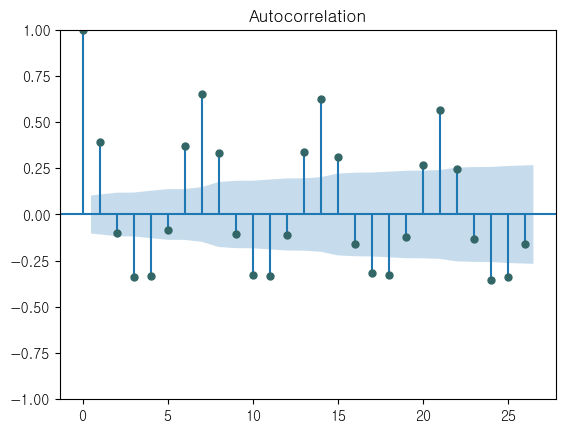

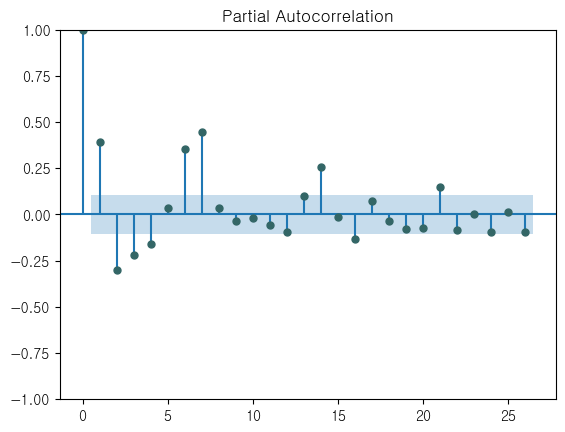

<Figure size 1000x1000 with 0 Axes>

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1722.991
Date:                           Thu, 09 May 2024   AIC                           3459.981
Time:                                   11:31:14   BIC                           3487.106
Sample:                                        0   HQIC                          3470.771
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2863      0.055     -5.212      0.000      -0.394      -0.179
ar.L2         -0.2338      0.054     -4.365

C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3112238735.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3112238735.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3112238735.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [29]:
check_forcast1 =[]
check_forcast1.append(sarima_test(강서_df1,주거_IDs,4,1,0,2,1,0,"주거",'06:00~10:00','대여'))

# 아리마 그리드 기법
- 지금 옮긴는 과정에서 결과값이 안나옴 -> 20240508_자료 확인

In [16]:
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)

top_20_ID = pd.read_csv('../../Data/따릉이/쏠림정도_top20_대여소.csv',encoding='utf-8')
# 주거와 상업으로 데이터 분할
주거_df = top_20_ID[top_20_ID['최종용도'] == '주거']
상업_df = top_20_ID[top_20_ID['최종용도'] == '상업']

# 주거 데이터에서 대여소_ID 추출
주거_IDs = 주거_df['대여소_ID'].unique()

# 상업 데이터에서 대여소_ID 추출
상업_IDs = 상업_df['대여소_ID'].unique()

강서_df3 = 강서_데이터[강서_데이터['시작_대여소_ID'].isin(주거_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df3 = 강서_df.sort_values(by='기준_날짜')

강서_df3['시간대_구간'] = 강서_df3['기준_시간대'].apply(divide_time_range)
강서_df4 = 강서_df3[강서_df3['시간대_구간'] == '06:00~10:00']     # 06~10 : , 17:21 :퇴근
강서_df4 = 강서_df4[(강서_df4['전체_이용_분'] != 0) & (강서_df4['전체_이용_거리'] != 0)]

강서_df4 = 강서_df4[['시작_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df4 = 강서_df4.rename(columns={'시작_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

arima_test(강서_df4,주거_IDs) # 주거 or 상업


C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3657298189.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3657298189.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ciw96\AppData\Local\Temp\ipykernel_23432\3657298189.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [11]:
강서_df1

,대여소_ID,기준_날짜,전체_건수
1599090,ST-1645,2023-04-03,1
1601475,ST-2557,2023-04-03,1
1601422,ST-1352,2023-04-03,1
1601391,ST-2056,2023-04-03,1
1601369,ST-1352,2023-04-03,1
...,...,...,...
3289207,ST-2056,2024-03-29,1
3289206,ST-2056,2024-03-29,1
3289174,ST-1645,2024-03-29,1
3289322,ST-2056,2024-03-29,1
